<a href="https://colab.research.google.com/github/kavinraam/train-delay-prediction-dashboard/blob/main/vaigai_train_delay_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
excel_path = r"/content/drive/MyDrive/Intern-CRIS/Dataset/Train Delay Prediction from CHE TO MDU/VAIGAI_TIMINGS.xlsx"
actual_df = pd.read_excel(excel_path, sheet_name="Transaction_Data")
actual_df.columns = actual_df.columns.str.strip().str.upper().str.replace(" ", "_")
print("Cleaned Columns in actual_df:", actual_df.columns.tolist())

Cleaned Columns in actual_df: ['SL_NO', 'TRAIN_NUMB', 'TRAINDATE', 'STTN_CODE', 'ARVL_TIME', 'DEP_TTIME']


In [ ]:
actual_df["ARVL_TIME"] = pd.to_datetime(actual_df["ARVL_TIME"], errors="coerce")
actual_df["DEP_TTIME"] = pd.to_datetime(actual_df["DEP_TTIME"], errors="coerce")
actual_df["TRAINDATE"] = pd.to_datetime(actual_df["TRAINDATE"], errors="coerce")

In [ ]:
referential_df = pd.read_excel(excel_path, sheet_name="Referential_data", header=2)

referential_df = referential_df[["Station Name & Code", "Arrives", "Departs", "Halt Time", "Distance"]]

referential_df.columns = ["STATION", "SCHED_ARVL", "SCHED_DEP", "HALT", "DISTANCE"]

referential_df["STTN_CODE"] = referential_df["STATION"].str.extract(r'-\s*(\w+)$')

referential_df["SCHED_ARVL"] = pd.to_datetime(
    referential_df["SCHED_ARVL"], format="%H:%M:%S", errors="coerce"
).dt.time

print("referential_df loaded and cleaned")
print(referential_df.head())

referential_df loaded and cleaned
                  STATION SCHED_ARVL SCHED_DEP HALT  DISTANCE STTN_CODE
0     Chennai Egmore - MS        NaT  13:45:00    -    0.0 km        MS
1          Tambaram - TBM   14:10:00  14:12:00   2m   24.5 km       TBM
2   Chengalpattu Jn - CGL   14:38:00  14:40:00   2m   55.5 km       CGL
3      Villupuram Jn - VM   15:55:00  16:00:00   5m  158.5 km        VM
4  Vriddhachalam Jn - VRI   16:40:00  16:42:00   2m  213.2 km       VRI


In [ ]:
merged_df = actual_df.merge(
    referential_df[["STTN_CODE", "SCHED_ARVL", "SCHED_DEP"]],
    on="STTN_CODE", how="left"
)

In [ ]:
valid_sched = merged_df["SCHED_ARVL"].notna()

merged_df.loc[valid_sched, "SCHED_ARVL_TIME"] = pd.to_datetime(
    merged_df.loc[valid_sched, "TRAINDATE"].dt.strftime("%Y-%m-%d") + " " +
    merged_df.loc[valid_sched, "SCHED_ARVL"].astype(str),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

In [ ]:
merged_df["ARVL_DELAY_MIN"] = (
    merged_df["ARVL_TIME"] - merged_df["SCHED_ARVL_TIME"]
).dt.total_seconds() / 60

In [ ]:
merged_df = merged_df[
    (merged_df["STTN_CODE"].notna()) &
    (merged_df["ARVL_DELAY_MIN"].notna()) &
    (merged_df["STTN_CODE"] != "MS")]

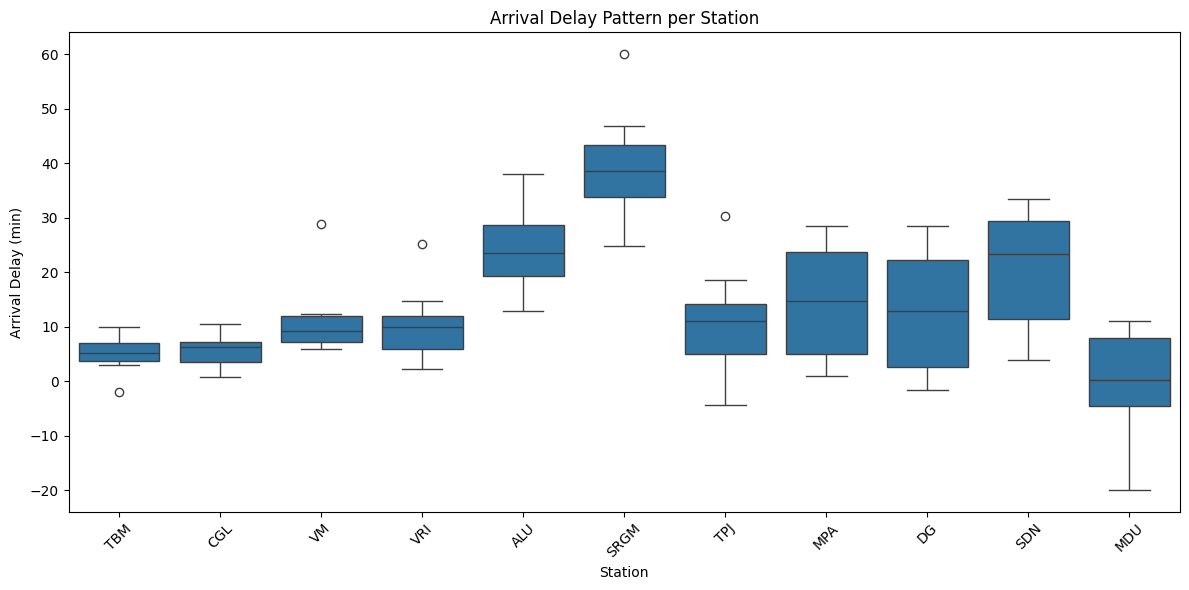

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x="STTN_CODE", y="ARVL_DELAY_MIN")
plt.title("Arrival Delay Pattern per Station")
plt.xlabel("Station")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-40-451131978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_delay, x="STTN_CODE", y="ARVL_DELAY_MIN", palette="coolwarm")


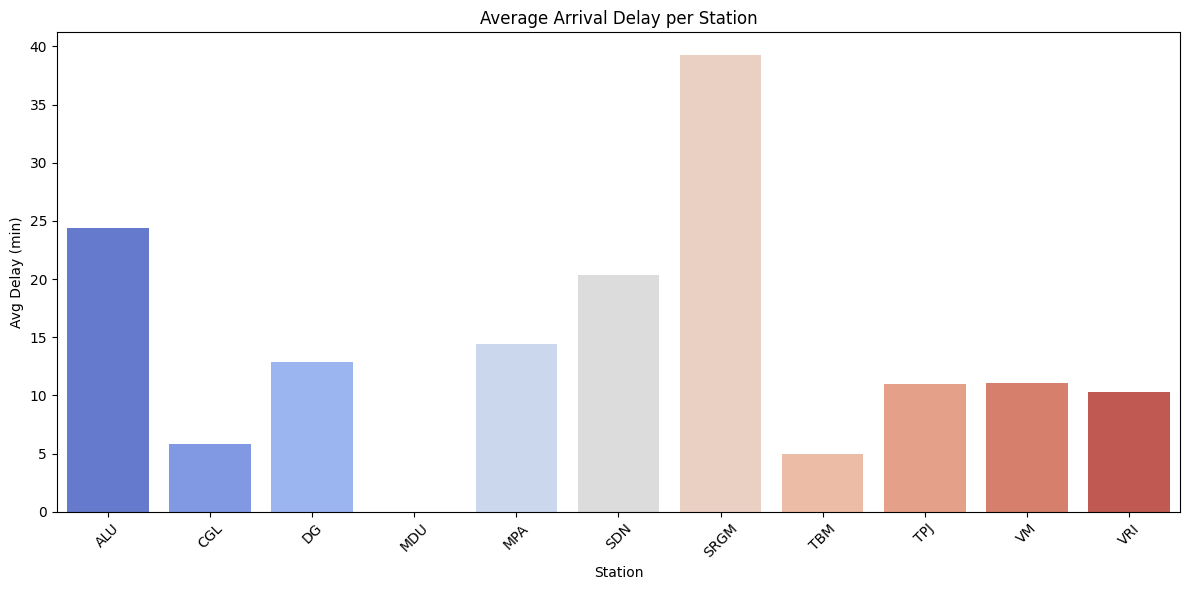

In [ ]:
mean_delay = merged_df.groupby("STTN_CODE")["ARVL_DELAY_MIN"].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_delay, x="STTN_CODE", y="ARVL_DELAY_MIN", palette="coolwarm")
plt.title("Average Arrival Delay per Station")
plt.xlabel("Station")
plt.ylabel("Avg Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

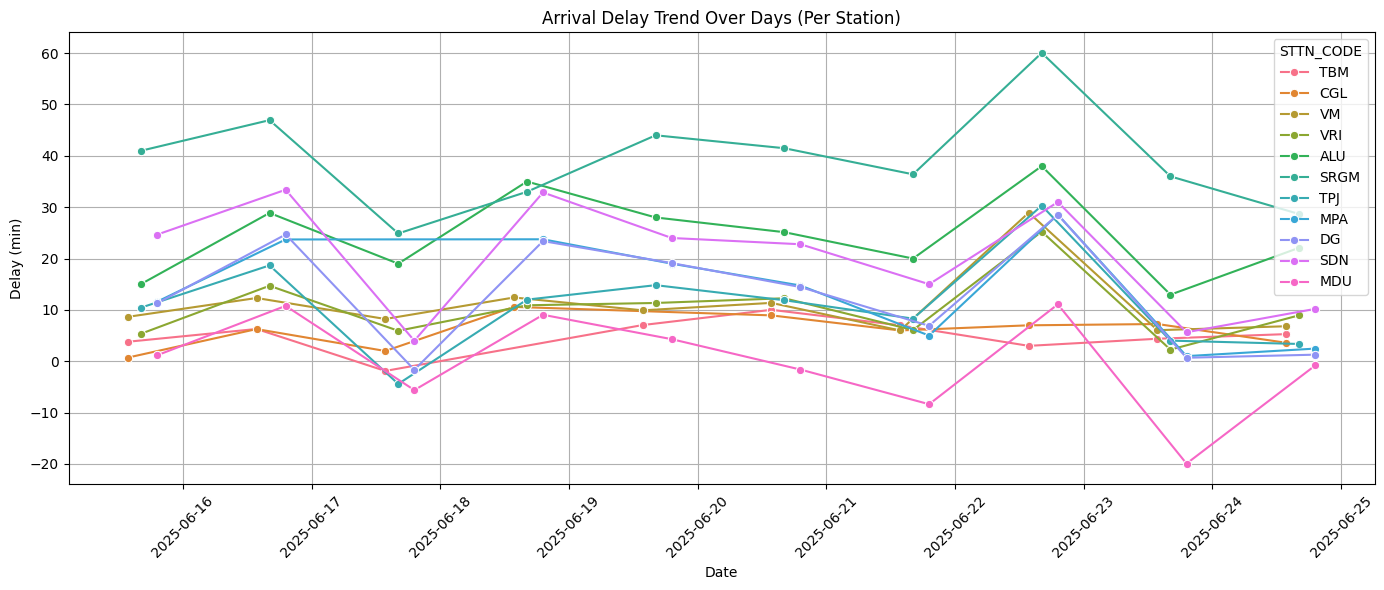

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=merged_df, x="TRAINDATE", y="ARVL_DELAY_MIN", hue="STTN_CODE", marker="o")
plt.title("Arrival Delay Trend Over Days (Per Station)")
plt.xlabel("Date")
plt.ylabel("Delay (min)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\nDelay Summary Table:")
delay_stats = merged_df.groupby("STTN_CODE")["ARVL_DELAY_MIN"].describe().round(2)
print(delay_stats)


Delay Summary Table:
           count   mean    std    min    25%    50%    75%    max
STTN_CODE                                                        
ALU         10.0  24.41   8.19  12.97  19.25  23.62  28.66  38.00
CGL          9.0   5.82   3.19   0.72   3.60   6.27   7.25  10.58
DG          10.0  12.87  10.90  -1.67   2.69  12.87  22.33  28.55
MDU         10.0   0.00   9.68 -19.93  -4.62   0.17   7.86  11.08
MPA          9.0  14.42  10.09   1.00   5.00  14.75  23.72  28.55
SDN         10.0  20.35  11.02   4.00  11.40  23.39  29.41  33.40
SRGM        10.0  39.24   9.99  24.88  33.75  38.69  43.37  60.05
TBM          9.0   4.99   3.32  -1.88   3.80   5.28   7.00  10.02
TPJ         10.0  10.94   9.43  -4.42   5.09  11.16  14.11  30.30
VM          10.0  11.07   6.72   6.00   7.17   9.28  12.08  28.93
VRI         10.0  10.31   6.46   2.27   5.97   9.93  12.04  25.25


Journey delay at MDU (final station):


,TRAINDATE,TOTAL_JOURNEY_DELAY
11,2025-06-15 19:10:00,1.150000
23,2025-06-16 19:10:00,10.783333
35,2025-06-17 19:10:00,-5.616667
47,2025-06-18 19:10:00,9.050000
58,2025-06-19 19:10:00,4.300000


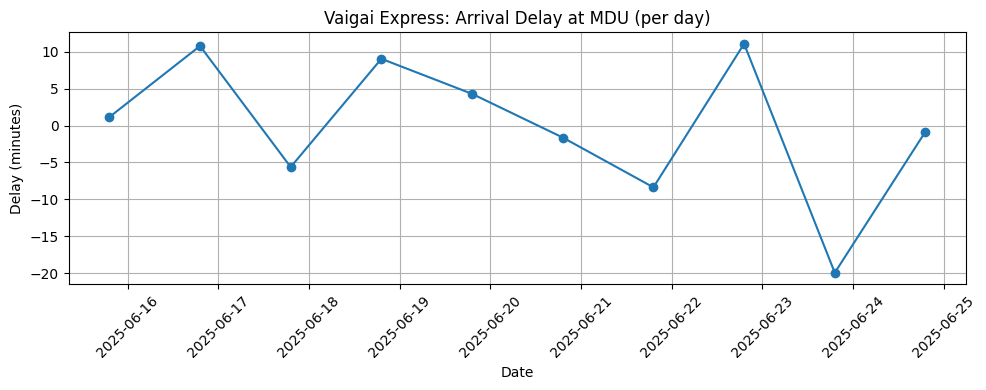

In [ ]:
merged_df.columns = merged_df.columns.str.strip()
merged_df["STTN_CODE"] = merged_df["STTN_CODE"].astype(str).str.strip()

end_df = merged_df[merged_df["STTN_CODE"] == "MDU"][["TRAINDATE", "ARVL_DELAY_MIN"]].dropna()

journey_delay_df = end_df.copy()
journey_delay_df.rename(columns={"ARVL_DELAY_MIN": "TOTAL_JOURNEY_DELAY"}, inplace=True)

print("Journey delay at MDU (final station):")
display(journey_delay_df.head())

plt.figure(figsize=(10, 4))
plt.plot(journey_delay_df["TRAINDATE"], journey_delay_df["TOTAL_JOURNEY_DELAY"], marker='o')
plt.title("Vaigai Express: Arrival Delay at MDU (per day)")
plt.xlabel("Date")
plt.ylabel("Delay (minutes)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#merged_df.to_csv("/content/drive/MyDrive/Intern-CRIS/merged_vaigai_df.csv", index=False)

In [ ]:
#ML PREDICTION
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

excel_path = "/content/drive/MyDrive/Intern-CRIS/Dataset/Train Delay Prediction from CHE TO MDU/VAIGAI_TIMINGS.xlsx"

actual_df = pd.read_excel(excel_path, sheet_name="Transaction_Data")
referential_df = pd.read_excel(excel_path, sheet_name="Referential_data", header=2)

actual_df.columns = actual_df.columns.str.strip().str.upper().str.replace(" ", "_")
referential_df = referential_df[["Station Name & Code", "Arrives", "Departs", "Halt Time", "Distance"]]
referential_df.columns = ["STATION", "SCHED_ARVL", "SCHED_DEP", "HALT", "DISTANCE"]
referential_df["STTN_CODE"] = referential_df["STATION"].str.extract(r'-\s*(\w+)$')

actual_df["ARVL_TIME"] = pd.to_datetime(actual_df["ARVL_TIME"], errors="coerce")
actual_df["DEP_TTIME"] = pd.to_datetime(actual_df["DEP_TTIME"], errors="coerce")
actual_df["TRAINDATE"] = pd.to_datetime(actual_df["TRAINDATE"], errors="coerce")

referential_df["SCHED_ARVL"] = pd.to_datetime(referential_df["SCHED_ARVL"], format="%H:%M:%S", errors="coerce").dt.time
referential_df["SCHED_DEP"] = pd.to_datetime(referential_df["SCHED_DEP"], format="%H:%M:%S", errors="coerce").dt.time
referential_df["HALT_MIN"] = referential_df["HALT"].str.extract(r"(\d+)").astype(float)
referential_df["DISTANCE_KM"] = referential_df["DISTANCE"].str.replace(" km", "", regex=False).astype(float)

merged_df = actual_df.merge(
    referential_df[["STTN_CODE", "SCHED_ARVL", "SCHED_DEP", "HALT_MIN", "DISTANCE_KM"]],
    on="STTN_CODE", how="left"
)

valid_sched = merged_df["SCHED_ARVL"].notna()
merged_df.loc[valid_sched, "SCHED_ARVL_TIME"] = pd.to_datetime(
    merged_df.loc[valid_sched, "TRAINDATE"].dt.strftime("%Y-%m-%d") + " " +
    merged_df.loc[valid_sched, "SCHED_ARVL"].astype(str),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

merged_df["ARVL_DELAY_MIN"] = (
    merged_df["ARVL_TIME"] - merged_df["SCHED_ARVL_TIME"]
).dt.total_seconds() / 60

valid_dep = merged_df["SCHED_DEP"].notna()
merged_df.loc[valid_dep, "SCHED_DEP_TIME"] = pd.to_datetime(
    merged_df.loc[valid_dep, "TRAINDATE"].dt.strftime("%Y-%m-%d") + " " +
    merged_df.loc[valid_dep, "SCHED_DEP"].astype(str),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

merged_df["DEP_DELAY_MIN"] = (
    merged_df["DEP_TTIME"] - merged_df["SCHED_DEP_TIME"]
).dt.total_seconds() / 60

merged_df["DAY_OF_WEEK"] = merged_df["TRAINDATE"].dt.dayofweek
merged_df["HOUR_OF_DAY"] = merged_df["TRAINDATE"].dt.hour
merged_df["IS_WEEKEND"] = merged_df["DAY_OF_WEEK"].isin([5, 6]).astype(int)

features = ["DAY_OF_WEEK", "HOUR_OF_DAY", "IS_WEEKEND", "HALT_MIN", "DEP_DELAY_MIN", "DISTANCE_KM"]
merged_df = merged_df.dropna(subset=["ARVL_DELAY_MIN", "DEP_DELAY_MIN", "HALT_MIN", "DISTANCE_KM"])
merged_df = merged_df[merged_df["ARVL_DELAY_MIN"].between(-100, 300)]

X = merged_df[features]
y = merged_df["ARVL_DELAY_MIN"]

imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(4, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("Best Parameters:", search.best_params_)
print(f"Optimized R² Score: {r2:.4f}")


Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
Optimized R² Score: 0.8305


In [ ]:
import joblib
joblib.dump(best_model, "vaigai_delay_model.pkl")

['vaigai_delay_model.pkl']

In [ ]:
import shutil
shutil.move("vaigai_delay_model.pkl", "/content/drive/MyDrive/Intern-CRIS/vaigai-train-delay-prediction/vaigai_delay_model.pkl")


'/content/drive/MyDrive/Intern-CRIS/vaigai-train-delay-prediction/vaigai_delay_model.pkl'